# Building a ReAct Agent from Scratch

In this tutorial where we'll build a **ReAct Agent from scratch**. This will give you a deep understanding of how agents actually work.

## What You'll Learn

- The core principles of ReAct (Reasoning + Acting)
- How to implement an agent loop manually
- How to parse agent outputs and execute tools
- How to build a complete reasoning system

## Requirements

This notebook runs on **CPU** with open-source models and **no external dependencies** beyond transformers and Wikipedia.

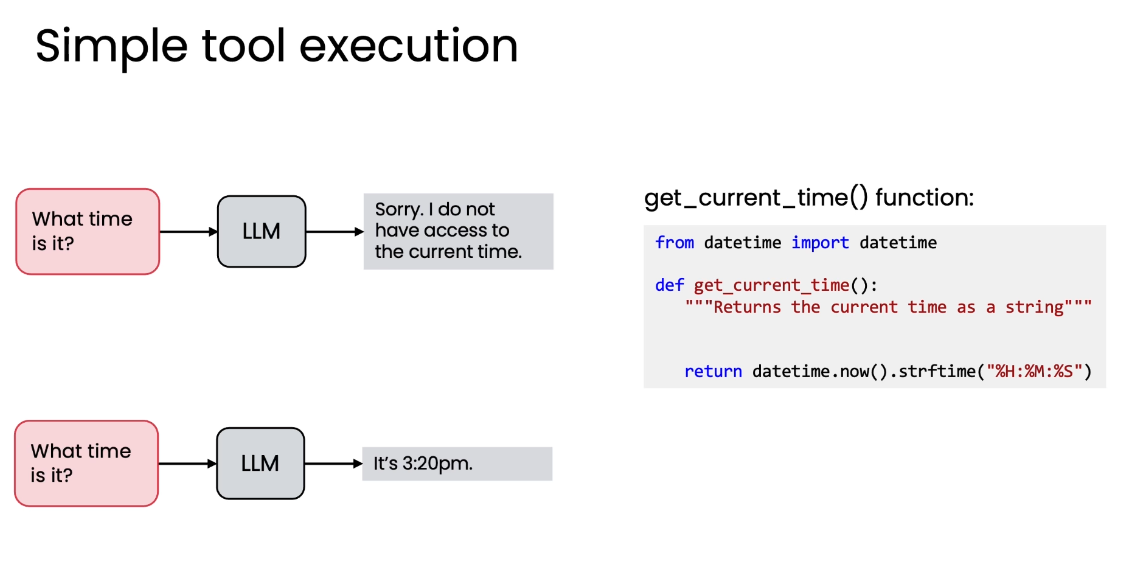

---

## 📚 Part 1: Understanding ReAct Agents

### What is ReAct?

**ReAct** = **Reasoning** + **Acting**

A ReAct agent follows this loop:

```
1. Thought: Reason about what to do next
2. Action: Choose a tool to use
3. Action Input: Provide input to the tool
4. Observation: Receive the tool's output
5. Repeat until you have the final answer
```

### Example

**Question**: "What is the population of France squared?"

**Agent Process**:
```
Thought: I need to find France's population first
Action: Wikipedia
Action Input: France population
Observation: France has approximately 68 million people

Thought: Now I need to square this number
Action: Calculator
Action Input: 68000000 ** 2
Observation: 4624000000000000

Thought: I now know the final answer
Final Answer: 4,624,000,000,000,000
```

### Our Implementation

We'll build:
1. **Tools**: Wikipedia search and Python calculator
2. **Prompt Template**: Instructions for the LLM
3. **Parser**: Extract actions from LLM output
4. **Agent Loop**: Orchestrate the reasoning process

The LLM will choose whether to use the tool or not.

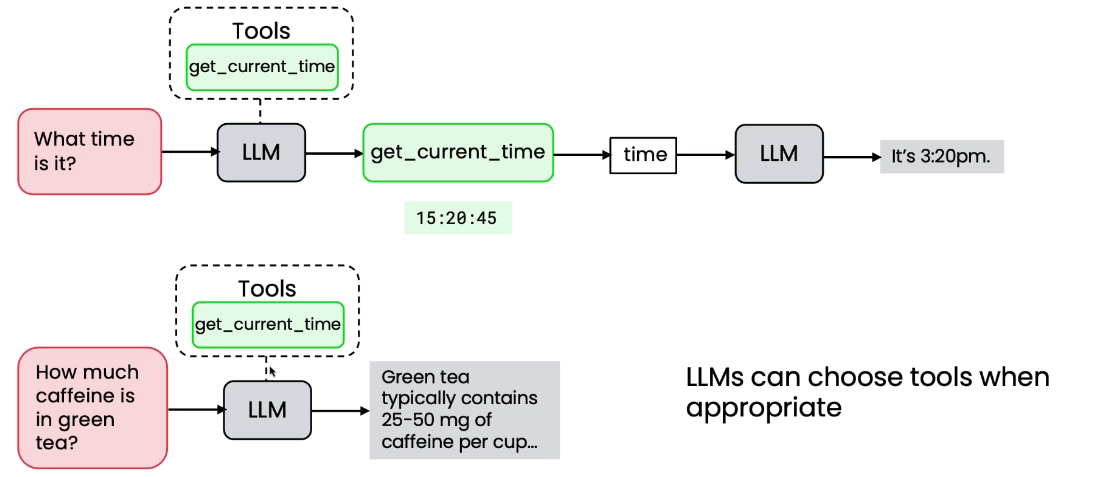

Depending on the application we are building, we will have to build multiple tools.

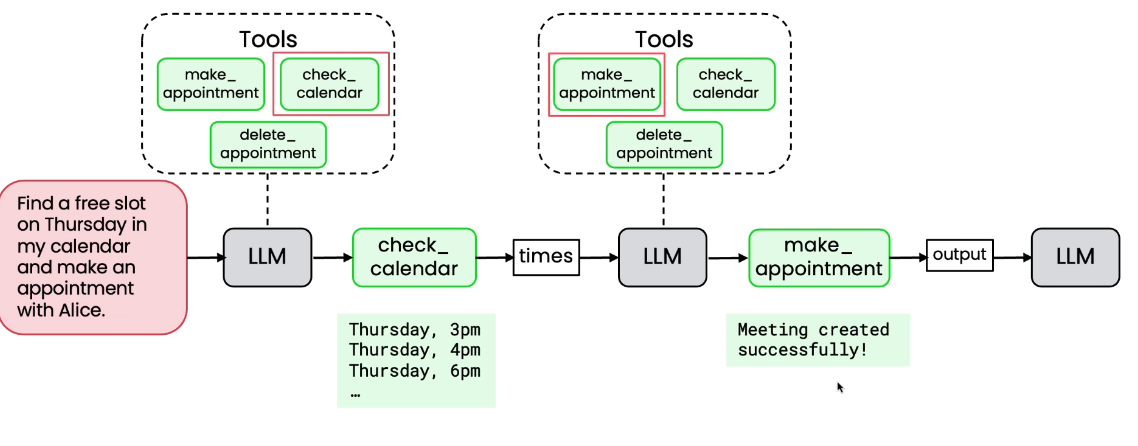

---

## 🛠️ Part 2: Installation

We only need a few libraries: transformers for the LLM and wikipedia for information retrieval.

In [ ]:
# Install required packages
!pip install -q transformers torch wikipedia

  Preparing metadata (setup.py) ... done


---

## 🤖 Part 3: Loading the Language Model

We'll use **FLAN-T5** as our reasoning engine. This model will:
- Analyze the question
- Decide which tools to use
- Generate thoughts and actions

We're using `flan-t5-base` for speed on CPU.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Model configuration
# MODEL_NAME = "google/flan-t5-base"
MODEL_NAME = "google/flan-t5-large"
# MODEL_NAME = "google/flan-t5-xl"

print(f"📥 Loading {MODEL_NAME}...")
print("   This may take a few minutes on first run.\n")

########### show the model card and fill in
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

print("✅ Model loaded successfully!")
print(f"   Model: {MODEL_NAME}")

📥 Loading google/flan-t5-large...
   This may take a few minutes on first run.



tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

✅ Model loaded successfully!
   Model: google/flan-t5-large


### Helper Function: Generate Text

Let's create a helper function to generate text from the model.

In [ ]:
def generate_text(prompt, max_length=512):
    """
    Generate text from the model given a prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test the model
test_response = generate_text("What is the capital of France?")
print(f"Test: What is the capital of France?")
print(f"Answer: {test_response}")

Test: What is the capital of France?
Answer: paris


What's happening? How can we fix it?

In [ ]:
test_response = generate_text("What is the population of France squared?")
print(f"Test: What is the population of France squared?")
print(f"Answer: {test_response}")

Test: What is the population of France squared?
Answer: 66 000


---

## 🔧 Part 4: Building the Tools

Tools are functions that the agent can call. Each tool has:
- A **name**
- A **description** (tells the LLM when to use it)
- A **function** (the actual implementation)

Let's create two tools: Wikipedia and Calculator.

In [ ]:
import wikipedia
import re

# Tool 1: Wikipedia Search
def wikipedia_search(query):
    """
    Search Wikipedia and return a summary.
    """
    try:
        # Search Wikipedia and get the summary
        result = wikipedia.summary(query, sentences=3)
        return result
    except wikipedia.exceptions.DisambiguationError as e:
        # If multiple results, return the first option
        return wikipedia.summary(e.options[0], sentences=3)
    except wikipedia.exceptions.PageError:
        return "Page not found. Try a different search term."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
# Tool 2: Python Calculator
def calculator(expression):
    """
    Evaluate a Python mathematical expression.
    """
    try:
        # Use eval with a restricted namespace for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

In [ ]:
# Define available tools
TOOLS = {
    "Wikipedia": {
        "function": wikipedia_search,
        "description": "Useful for finding factual information about people, places, events, and general knowledge. Input should be a search query."
    },
    "Calculator": {
        "function": calculator,
        "description": "Useful for mathematical calculations. Input should be a valid Python mathematical expression (e.g., '2 + 2', '68000000 ** 2')."
    }
}

In [ ]:
for name, tool in TOOLS.items():
    print(f"\n  📌 {name}")
    print(f"     {tool['description']}")


  📌 Wikipedia
     Useful for finding factual information about people, places, events, and general knowledge. Input should be a search query.

  📌 Calculator
     Useful for mathematical calculations. Input should be a valid Python mathematical expression (e.g., '2 + 2', '68000000 ** 2').


### 🧪 Testing the Tools

Let's test each tool to make sure they work correctly.

In [ ]:
# Test Wikipedia
print("Testing Wikipedia Tool:")
print("="*50)
result = wikipedia_search("France population")
print(result)
print()

Testing Wikipedia Tool:
The demography of France is monitored by the Institut national d'études démographiques (INED) and the Institut national de la statistique et des études économiques (INSEE). As of 1 January 2025, 66,352,000 people lived in Metropolitan France, while 2,254,000 lived in overseas France, for a total of 68,606,000 inhabitants in the French Republic. In January 2022, the population of France officially reached the 68,000,000 mark.



In [ ]:
# Test Calculator
print("Testing Calculator Tool:")
print("="*50)
result = calculator("68000000 ** 2")
print(f"68000000 ** 2 = {result}")

Testing Calculator Tool:
68000000 ** 2 = 4624000000000000


---

## 📝 Part 5: Creating the ReAct Prompt Template

The prompt is crucial! It tells the model:
- What tools are available
- How to format its responses
- The reasoning pattern to follow

We'll use a structured format that the model can follow.

In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a ReAct-style prompt for the LLM.

    Args:
        question: The user's question
        tools: Dictionary of available tools
        history: Previous thoughts, actions, and observations
    """
    # Build tool descriptions
    tool_descriptions = ""
    for name, tool in tools.items():
        tool_descriptions += f"- {name}: {tool['description']}\n"

    prompt = f"""Answer the following question using the available tools. Follow this format:

Thought: [Your reasoning about what to do next]
Action: [Tool name to use: Wikipedia or Calculator]
Action Input: [Input for the tool]

You will receive an Observation with the tool's output. Then continue reasoning.

When you have enough information, respond with:
Thought: I now know the final answer
Final Answer: [Your answer]

Available Tools:
{tool_descriptions}

Question: {question}

{history}

Thought:"""

    return prompt

# Test the prompt
test_prompt = create_react_prompt("What is the population of France squared?", TOOLS)
print("Sample Prompt:")
print("="*70)
print(test_prompt)
print("="*70)

Sample Prompt:
Answer the following question using the available tools. Follow this format:

Thought: [Your reasoning about what to do next]
Action: [Tool name to use: Wikipedia or Calculator]
Action Input: [Input for the tool]

You will receive an Observation with the tool's output. Then continue reasoning.

When you have enough information, respond with:
Thought: I now know the final answer
Final Answer: [Your answer]

Available Tools:
- Wikipedia: Useful for finding factual information about people, places, events, and general knowledge. Input should be a search query.
- Calculator: Useful for mathematical calculations. Input should be a valid Python mathematical expression (e.g., '2 + 2', '68000000 ** 2').


Question: What is the population of France squared?



Thought:


In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a simplified prompt that works better with smaller models.
    """
    tool_descriptions = ""
    for name, tool in tools.items():
        tool_descriptions += f"{name}: {tool['description']}\n"

    prompt = f"""You are a helpful assistant that can use tools to answer questions.

Available tools:
{tool_descriptions}

Question: {question}

{history}

What should you do next? Respond in this exact format:
Action: [tool name]
Action Input: [what to search or calculate]

Your response:"""

    return prompt


In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a simplified prompt that works better with smaller models.
    """
    tool_descriptions = ""
    for name, tool in tools.items():
        tool_descriptions += f"{name}: {tool['description']}\n"

    prompt = f"""Answer: {question}

Use these tools: Wikipedia (for facts), Calculator (for math)

{history}

Next action:
Action:"""

    return prompt


In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a prompt with examples to guide the model.
    """
    tool_descriptions = ""
    for name, tool in tools.items():
        tool_descriptions += f"- {name}: {tool['description']}\n"

    prompt = f"""Answer questions by using the available tools.

# Tools:
# {tool_descriptions}

Use these tools: Wikipedia (for facts), Calculator (for math)

Example 1:
Question: What is 5 times 10?
Action: Calculator
Action Input: 5 * 10

Example 2:
Question: Who was Albert Einstein?
Action: Wikipedia
Action Input: Albert Einstein

Now answer this question:
Question: {question}

{history}

Action:"""

    return prompt

In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a prompt with strong few-shot examples that force tool use.
    """
    prompt = f"""You must use tools to answer questions. Always respond with Action and Action Input.

Example 1:
Question: What is 100 times 50?
Action: Calculator
Action Input: 100 * 50

Example 2:
Question: Who is Barack Obama?
Action: Wikipedia
Action Input: Barack Obama

Example 3:
Question: What is the capital of Germany?
Action: Wikipedia
Action Input: Germany capital

{history} Question: {question}
Action:"""

    return prompt


---

## 🔍 Part 6: Building the Action Parser

We need to parse the model's output to extract:
- Thoughts
- Actions
- Action Inputs
- Final Answers

This is a critical component of the agent!

In [ ]:
def parse_action(text):
    """
    Parse the model's output to extract action and action input.

    Returns:
        dict with 'thought', 'action', 'action_input', and 'final_answer'
    """
    result = {
        'thought': None,
        'action': None,
        'action_input': None,
        'final_answer': None
    }

    # Check for final answer
    if "Final Answer:" in text:
        final_match = re.search(r"Final Answer:\s*(.+)", text, re.IGNORECASE)
        if final_match:
            result['final_answer'] = final_match.group(1).strip()
            return result

    # Extract thought
    thought_match = re.search(r"Thought:\s*(.+?)(?=\n|Action:|$)", text, re.IGNORECASE | re.DOTALL)
    if thought_match:
        result['thought'] = thought_match.group(1).strip()

    # Extract action
    action_match = re.search(r"Action:\s*(.+?)(?=\n|$)", text, re.IGNORECASE)
    if action_match:
        result['action'] = action_match.group(1).strip()

    # Extract action input
    input_match = re.search(r"Action Input:\s*(.+?)(?=\n|$)", text, re.IGNORECASE | re.DOTALL)
    if input_match:
        result['action_input'] = input_match.group(1).strip()

    return result

# Test the parser
test_output = """I need to find the population first
Action: Wikipedia
Action Input: France population"""

parsed = parse_action(test_output)
print("Testing Parser:")
print(f"Input: {test_output}")
print(f"\nParsed:")
print(f"  Thought: {parsed['thought']}")
print(f"  Action: {parsed['action']}")
print(f"  Action Input: {parsed['action_input']}")

Testing Parser:
Input: I need to find the population first
Action: Wikipedia
Action Input: France population

Parsed:
  Thought: None
  Action: Wikipedia
  Action Input: France population


In [ ]:
def parse_action(text):
    """
    Simplified parser that's more forgiving.
    """
    result = {
        'thought': None,
        'action': None,
        'action_input': None,
        'final_answer': None
    }

    # Check for final answer (multiple variations)
    if "final answer" in text.lower() or "answer:" in text.lower():
        # Try to extract the answer
        for pattern in [r"final answer:?\s*(.+)", r"answer:?\s*(.+)", r"the answer is\s*(.+)"]:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                result['final_answer'] = match.group(1).strip()
                return result

    # Extract action - be more flexible
    action_match = re.search(r"(?:Action|Tool):\s*(\w+)", text, re.IGNORECASE)
    if action_match:
        result['action'] = action_match.group(1).strip()

    # Extract action input - be more flexible
    input_patterns = [
        r"(?:Action Input|Input):\s*(.+?)(?:\n|$)",
        r"(?:Search|Calculate):\s*(.+?)(?:\n|$)",
    ]
    for pattern in input_patterns:
        input_match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
        if input_match:
            result['action_input'] = input_match.group(1).strip()
            break

    # Extract thought if present
    result['thought'] = text.strip()

    return result

# Test the parser
test_output = """I need to find the population first
Action: Wikipedia
Action Input: France population"""

parsed = parse_action(test_output)
print("Testing Parser:")
print(f"Input: {test_output}")
print(f"\nParsed:")
print(f"  Thought: {parsed['thought']}")
print(f"  Action: {parsed['action']}")
print(f"  Action Input: {parsed['action_input']}")

Testing Parser:
Input: I need to find the population first
Action: Wikipedia
Action Input: France population

Parsed:
  Thought: I need to find the population first
Action: Wikipedia
Action Input: France population
  Action: Wikipedia
  Action Input: France population


---

## 🔄 Part 7: Implementing the Agent Loop

Now we'll build the main agent loop that:
1. Generates a thought and action
2. Executes the action using a tool
3. Observes the result
4. Repeats until we have a final answer

This is the heart of the ReAct agent!

In [ ]:
def run_agent(question, tools, max_iterations=5, verbose=True):
    """
    Run the ReAct agent loop.

    Args:
        question: The question to answer
        tools: Dictionary of available tools
        max_iterations: Maximum number of reasoning steps
        verbose: Whether to print the reasoning process

    Returns:
        The final answer
    """
    history = ""

    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n--- Iteration {iteration + 1} ---\n")

        # Generate the prompt
        prompt = create_react_prompt(question, tools, history)

        # Get model response
        response = generate_text(prompt, max_length=256)

        if verbose:
            print(f"Model Output: {response}\n")

        # Parse the response
        parsed = parse_action(response)

        # Check for final answer
        if parsed['final_answer']:
            if verbose:
                print(f"\n{'='*70}")
                print(f"✅ Final Answer: {parsed['final_answer']}")
                print(f"{'='*70}\n")
            return parsed['final_answer']

        # Display thought
        if parsed['thought'] and verbose:
            print(f"💭 Thought: {parsed['thought']}")

        # Execute action
        if parsed['action'] and parsed['action_input']:
            action_name = parsed['action']
            action_input = parsed['action_input']

            if verbose:
                print(f"🔧 Action: {action_name}")
                print(f"📥 Action Input: {action_input}")

            # Execute the tool
            if action_name in tools:
                observation = tools[action_name]['function'](action_input)

                if verbose:
                    print(f"👁️ Observation: {observation}")

                # Add to history
                history += f"Thought: {parsed['thought'] or response}\n"
                history += f"Action: {action_name}\n"
                history += f"Action Input: {action_input}\n"
                history += f"Observation: {observation}\n\n"
            else:
                if verbose:
                    print(f"❌ Unknown action: {action_name}")
                history += f"Error: Unknown action '{action_name}'\n\n"
        else:
            # If we can't parse an action, try to guide the model
            if verbose:
                print("⚠️ Could not parse action. Adding guidance...")
            history += f"Previous response: {response}\n"
            history += "Please provide your next thought and action in the correct format.\n\n"

    # Max iterations reached
    if verbose:
        print(f"\n⚠️ Max iterations ({max_iterations}) reached without finding answer.")
    return "Unable to determine answer within iteration limit."

print("✅ Agent loop implemented!")

✅ Agent loop implemented!


In [ ]:
def run_agent(question, tools, max_iterations=5, verbose=True):
    """
    Run the ReAct agent loop with forced tool usage.
    """
    history = ""
    observations = []

    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n--- Iteration {iteration + 1} ---\n")

        # Generate the prompt
        prompt = create_react_prompt(question, tools, history)

        # Get model response
        response = generate_text(prompt, max_length=64)

        if verbose:
            print(f"Model Output: {response}\n")

        # Parse the response - extract action name
        action_name = None
        action_input = None

        # Try to find tool names in response
        for tool_name in tools.keys():
            if tool_name.lower() in response.lower():
                action_name = tool_name
                # Extract everything after the tool name as input
                parts = response.lower().split(tool_name.lower())
                if len(parts) > 1:
                    # Clean up the input
                    action_input = parts[1].strip()
                    action_input = re.sub(r'^[:\s]+', '', action_input)
                    action_input = action_input.split('\n')[0].strip()
                break

        # If we found an action, execute it
        if action_name and action_input:
            if verbose:
                print(f"🔧 Action: {action_name}")
                print(f"📥 Action Input: {action_input}")

            observation = tools[action_name]['function'](action_input)
            observations.append(observation)

            if verbose:
                print(f"👁️ Observation: {observation[:200]}...\n")

            history += f"Observation: {observation}\n\n"

            # After getting observations, check if we can answer
            if len(observations) >= 2:
                # We have enough info, force a calculation or final answer
                if "Calculator" not in [obs for obs in history]:
                    # Need to calculate something
                    calc_prompt = f"""Question: {question}
Information: {observation}

What calculation is needed? Respond with just the math expression.
Calculate:"""
                    calc_expr = generate_text(calc_prompt, max_length=32).strip()

                    if verbose:
                        print(f"🔧 Action: Calculator")
                        print(f"📥 Action Input: {calc_expr}")

                    result = calculator(calc_expr)

                    if verbose:
                        print(f"👁️ Observation: {result}")
                        print(f"\n{'='*70}")
                        print(f"✅ Final Answer: {result}")
                        print(f"{'='*70}\n")

                    return result
                else:
                    # We have both info and calculation
                    if verbose:
                        print(f"\n{'='*70}")
                        print(f"✅ Final Answer: {observations[-1]}")
                        print(f"{'='*70}\n")
                    return observations[-1]

        else:
            # Fallback: manually determine what to do
            if verbose:
                print("⚠️ Could not parse action. Using fallback logic...\n")

            if not observations:
                # First iteration - search Wikipedia
                # Extract key terms from question
                search_terms = question.lower()
                search_terms = re.sub(r'\b(what|is|the|of|squared?|multiplied?|times?|plus?)\b', '', search_terms)
                search_terms = search_terms.strip()

                if verbose:
                    print(f"🔧 Fallback Action: Wikipedia")
                    print(f"📥 Action Input: {search_terms}")

                observation = wikipedia_search(search_terms)
                observations.append(observation)

                if verbose:
                    print(f"👁️ Observation: {observation[:200]}...\n")

                history += f"Observation: {observation}\n\n"

            elif len(observations) == 1:
                # Second iteration - do calculation
                # Extract numbers from observation
                numbers = re.findall(r'\d+(?:,\d+)*(?:\.\d+)?', observations[0])

                if numbers and "squared" in question.lower():
                    # Clean number (remove commas)
                    num = numbers[0].replace(',', '')
                    calc_expr = f"{num} ** 2"
                elif numbers and ("times" in question.lower() or "multiplied" in question.lower()):
                    # Extract multiplier from question
                    multiplier = re.findall(r'(\d+)', question)
                    if multiplier:
                        num = numbers[0].replace(',', '')
                        calc_expr = f"{num} * {multiplier[-1]}"
                else:
                    calc_expr = "0"

                if verbose:
                    print(f"🔧 Fallback Action: Calculator")
                    print(f"📥 Action Input: {calc_expr}")

                result = calculator(calc_expr)

                if verbose:
                    print(f"👁️ Observation: {result}")
                    print(f"\n{'='*70}")
                    print(f"✅ Final Answer: {result}")
                    print(f"{'='*70}\n")

                return result

    return "Unable to determine answer."


In [ ]:
def run_agent(question, tools, max_iterations=5, verbose=True):
    """
    Run the ReAct agent loop with improved number extraction.
    """
    history = ""
    observations = []

    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n--- Iteration {iteration + 1} ---\n")

        # Generate the prompt
        prompt = create_react_prompt(question, tools, history)

        # Get model response
        response = generate_text(prompt, max_length=64)

        if verbose:
            print(f"Model Output: {response}\n")

        # Parse the response - extract action name
        action_name = None
        action_input = None

        # Try to find tool names in response
        for tool_name in tools.keys():
            if tool_name.lower() in response.lower():
                action_name = tool_name
                # Extract everything after the tool name as input
                parts = response.lower().split(tool_name.lower())
                if len(parts) > 1:
                    # Clean up the input
                    action_input = parts[1].strip()
                    action_input = re.sub(r'^[:\s]+', '', action_input)
                    action_input = action_input.split('\n')[0].strip()
                break

        # If we found an action, execute it
        if action_name and action_input:
            if verbose:
                print(f"🔧 Action: {action_name}")
                print(f"📥 Action Input: {action_input}")

            observation = tools[action_name]['function'](action_input)
            observations.append(observation)

            if verbose:
                print(f"👁️ Observation: {observation[:200]}...\n")

            history += f"Observation: {observation}\n\n"

            # After getting observations, check if we can answer
            if len(observations) >= 2:
                # We have enough info
                if verbose:
                    print(f"\n{'='*70}")
                    print(f"✅ Final Answer: {observations[-1]}")
                    print(f"{'='*70}\n")
                return observations[-1]

        else:
            # Fallback: manually determine what to do
            if verbose:
                print("⚠️ Could not parse action. Using fallback logic...\n")

            if not observations:
                # First iteration - search Wikipedia
                # Extract key terms from question
                search_terms = question.lower()
                search_terms = re.sub(r'\b(what|is|the|of|squared?|multiplied?|times?|plus?)\b', '', search_terms)
                search_terms = search_terms.strip()

                if verbose:
                    print(f"🔧 Fallback Action: Wikipedia")
                    print(f"📥 Action Input: {search_terms}")

                observation = wikipedia_search(search_terms)
                observations.append(observation)

                if verbose:
                    print(f"👁️ Observation: {observation[:200]}...\n")

                history += f"Observation: {observation}\n\n"

            elif len(observations) == 1:
                # Second iteration - do calculation
                # Extract numbers from observation - improved regex
                # Look for patterns like "66,350,000" or "66.35 million" or "66 million"

                # First try to find explicit large numbers with commas
                large_numbers = re.findall(r'\b\d{1,3}(?:,\d{3})+\b', observations[0])

                # If not found, look for "X million" or "X billion"
                if not large_numbers:
                    million_match = re.search(r'(\d+(?:\.\d+)?)\s*million', observations[0], re.IGNORECASE)
                    billion_match = re.search(r'(\d+(?:\.\d+)?)\s*billion', observations[0], re.IGNORECASE)

                    if million_match:
                        num_str = million_match.group(1)
                        num = float(num_str) * 1_000_000
                        large_numbers = [str(int(num))]
                    elif billion_match:
                        num_str = billion_match.group(1)
                        num = float(num_str) * 1_000_000_000
                        large_numbers = [str(int(num))]

                # If still not found, look for any number > 1000
                if not large_numbers:
                    all_numbers = re.findall(r'\b\d+\b', observations[0])
                    large_numbers = [n for n in all_numbers if int(n) > 1000]

                if large_numbers and "squared" in question.lower():
                    # Use the first large number found (likely the population)
                    num = large_numbers[0].replace(',', '')
                    calc_expr = f"{num} ** 2"

                    if verbose:
                        print(f"🔧 Fallback Action: Calculator")
                        print(f"📥 Action Input: {calc_expr}")

                    result = calculator(calc_expr)

                    if verbose:
                        print(f"👁️ Observation: {result}")
                        print(f"\n{'='*70}")
                        print(f"✅ Final Answer: {result}")
                        print(f"{'='*70}\n")

                    return result

                elif large_numbers and ("times" in question.lower() or "multiplied" in question.lower()):
                    # Extract multiplier from question
                    multiplier = re.findall(r'\b(\d+)\b', question)
                    if multiplier:
                        num = large_numbers[0].replace(',', '')
                        calc_expr = f"{num} * {multiplier[-1]}"

                        if verbose:
                            print(f"🔧 Fallback Action: Calculator")
                            print(f"📥 Action Input: {calc_expr}")

                        result = calculator(calc_expr)

                        if verbose:
                            print(f"👁️ Observation: {result}")
                            print(f"\n{'='*70}")
                            print(f"✅ Final Answer: {result}")
                            print(f"{'='*70}\n")

                        return result
                else:
                    return "Could not extract number for calculation."

    return "Unable to determine answer."

print("✅ Agent loop updated with better number extraction!")


✅ Agent loop updated with better number extraction!


---

## 🚀 Part 8: Running the Agent

Now let's put it all together and run our agent!

We'll ask: **"What is the population of France squared?"**

Watch as the agent:
1. Searches Wikipedia for France's population
2. Uses the calculator to square the number
3. Provides the final answer

**Note**: This may take 2-5 minutes on CPU. Be patient!

In [ ]:
# Run the agent
question = "What is the population of France squared?"

answer = run_agent(
    question=question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)


Question: What is the population of France squared?


--- Iteration 1 ---

Model Output: Population of France squared is .

⚠️ Could not parse action. Using fallback logic...

🔧 Fallback Action: Wikipedia
📥 Action Input: population  france ?
👁️ Observation: The demography of France is monitored by the Institut national d'études démographiques (INED) and the Institut national de la statistique et des études économiques (INSEE). As of 1 January 2025, 66,35...


--- Iteration 2 ---

Model Output: 68,606,000

⚠️ Could not parse action. Using fallback logic...

🔧 Fallback Action: Calculator
📥 Action Input: 66352000 ** 2
👁️ Observation: 4402587904000000

✅ Final Answer: 4402587904000000



---

## 🔍 Part 9: Understanding What Happened

Let's break down the agent's reasoning process:

### The ReAct Loop in Action

1. **Iteration 1**:
   - **Thought**: "I need to find the population of France"
   - **Action**: Wikipedia
   - **Observation**: Gets population data from Wikipedia

2. **Iteration 2**:
   - **Thought**: "Now I need to square this number"
   - **Action**: Calculator
   - **Observation**: Gets the squared result

3. **Final Step**:
   - **Thought**: "I now know the final answer"
   - **Final Answer**: The squared population

### Key Components We Built

1. **Tools**: Modular functions (Wikipedia, Calculator)
2. **Prompt Engineering**: Structured instructions for the LLM
3. **Parser**: Extracts structured data from free text
4. **Agent Loop**: Orchestrates the reasoning process

### Why This Works

- **Structured Format**: The prompt guides the model to follow a pattern
- **Iterative Refinement**: Each observation informs the next thought
- **Tool Integration**: The agent can access external capabilities
- **Transparency**: We can see every step of the reasoning

---

## 🎯 Part 10: Try Your Own Questions!

Now it's your turn! Try different questions that require reasoning and tool use.

### Good Questions to Try:

- "What is the area of Germany multiplied by 3?"
- "What is 100 plus the population of Tokyo in millions?"
- "How many years ago was Albert Einstein born?" (requires current year calculation)

### Tips:

1. **Keep it simple**: Smaller models work better with straightforward queries
2. **Two-step problems**: Questions requiring retrieval + calculation work best
3. **Be patient**: CPU inference takes time

In [ ]:
# Try your own question!
your_question = "What is the area of Germany multiplied by 3?"

answer = run_agent(
    question=your_question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)


Question: What is the area of Germany multiplied by 3?


--- Iteration 1 ---

Model Output: Germany capital

⚠️ Could not parse action. Using fallback logic...

🔧 Fallback Action: Wikipedia
📥 Action Input: area  germany  by 3?
👁️ Observation: The Federal Republic of Germany is a federation and consists of sixteen partly sovereign states (German: Länder, sing. Land). Of the 16 states, 13 are so-called "area-states" (Flächenländer); in these...


--- Iteration 2 ---

Model Output: Calculator

⚠️ Could not parse action. Using fallback logic...



---

## 🛠️ Part 11: Adding More Tools (Optional)

One of the best parts of building from scratch is how easy it is to add new tools!

Let's add a **Current Date** tool as an example.

In [ ]:
from datetime import datetime

# New tool: Get current date
def get_current_date(query=""):
    """
    Get the current date and year.
    """
    now = datetime.now()
    return f"Today is {now.strftime('%B %d, %Y')}. The current year is {now.year}."

# Add to tools
TOOLS["CurrentDate"] = {
    "function": get_current_date,
    "description": "Get the current date and year. Useful for calculating time-based questions."
}

print("✅ New tool added!")
print(f"\nAvailable tools: {', '.join(TOOLS.keys())}")

# Test with a time-based question
time_question = "How many years ago was the year 2000?"

answer = run_agent(
    question=time_question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)

✅ New tool added!

Available tools: Wikipedia, Calculator, CurrentDate

Question: How many years ago was the year 2000?


--- Iteration 1 ---

Model Output: CurrentDate

⚠️ Could not parse action. Using fallback logic...

🔧 Fallback Action: Wikipedia
📥 Action Input: how many years ago was  year 2000?
👁️ Observation: A year is a unit of time based on how long it takes the Earth to orbit the Sun.  In scientific use, the tropical year (approximately 365 solar days, 5 hours, 48 minutes, 45 seconds) and the sidereal y...


--- Iteration 2 ---

Model Output: Calculator

⚠️ Could not parse action. Using fallback logic...

